In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_fscore_support
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline

# Read CSV
data = pd.read_csv('OnlineNewsPopularity_ForModeling.csv',index_col='url')

In [2]:
def plot_confusion_matrix(cm,classes,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    Prints and plots a confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def popularity(data,thresh,col_name):
    """
    Labels data as 'popular' or 'unpopular' based on a given threshold.
    """
    data.loc[data[(data['shares'] > thresh)].index,col_name] = 'popular'
    data.loc[data[data['shares'] <= thresh].index,col_name] = 'unpopular'
    return data.drop(columns='shares')

def lim_entries(data,col_name,both=False,i=1):
    """
    Limits data so that the number of entries in a given column are equal.
    """
    entries = data[col_name].value_counts().index[:-1]
    n = data[col_name].value_counts()[-1]*i
    new = data.loc[data[col_name] == data[col_name].value_counts().index[-1]]
    
    for entry in entries:
        selected = data[data[col_name] == entry].reset_index()
        selected_col = selected.columns
        index = selected_col[0]
        selected = pd.DataFrame(np.random.permutation(selected)[:n],columns=selected_col).set_index(index)
        new = new.append(selected)  
    if both == True:
        new = [new,data.drop(index=list(new.index))]
    return new

def split_data(data,thresh,y_var='popularity',lim_i=0):
    """
    Labels entries as popular and unpopular given a certain threshold then limits data such that 
    the two labels have an equal amount of entries. Then splits data into training and testing
    sets. 
    """
    if lim_i == None:
        lim_i = 0
        
    data = popularity(data,thresh=thresh,col_name=y_var)
    y_var_values = data[y_var].unique()
    
    if lim_i != 0:
        data, cut_data = lim_entries(data,col_name=y_var,both=True,i=lim_i)
        X_cut = cut_data.drop(columns=y_var)
        y_cut = cut_data[y_var].replace(y_var_values,range(len(y_var_values)))
    else:
        cut_data = None
    
    # use the selected y_var to seperate the X and Y variables
    X = data.drop(columns=y_var)
    y = data[y_var].replace(y_var_values,range(len(y_var_values)))

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,stratify=y)
    
    if lim_i != 0:
        X_test = X_test.append(X_cut)
        y_test = y_test.append(y_cut)
    
    return X_train, X_test, y_train, y_test

def best_params(X,y,grid_params,score='f1'):
    """
    Finds best depth of the model based off of the 
    """
    pipe = Pipeline(steps=[('scaler', StandardScaler()), ('random_forest', RandomForestClassifier())])
    grid = GridSearchCV(pipe,param_grid=grid_params,scoring=score)
    grid.fit(X,y)
    
    return grid.best_params_

def make_model(X,y,depth=10,n=100):
    """
    Makes a random forest model based off given parameters/
    """
    random_forest = RandomForestClassifier(max_depth=depth,n_estimators=n)
    pipe = Pipeline(steps=[('scaler', StandardScaler()), ('random_forest', random_forest)])
    pipe.fit(X,y)
    return pipe
    
def test_model(model, X, y,print_score=True,plots=False,feat_importance=False):
    """
    Plots confusion matrix, roc curve, and f1 scores
    """
    
    if type(X) == tuple:
        X_train,X_test = X
        y_train,y_test = y
    
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    
        y_pred_train_proba = model.predict_proba(X_train)[:, 1]
        y_pred_test_proba = model.predict_proba(X_test)[:, 1]
    
        # precision, recall, and fscore_
        accuracy = precision_recall_fscore_support(y_test, y_pred_test,average='binary')
        accuracy = pd.DataFrame(accuracy[:-1], index=['precision','recall','f1_score']).T
        
        if print_score == True:
            print(accuracy)
        
    else:
        y_pred = model.predict(X)
        accuracy = precision_recall_fscore_support(y, y_pred,average='binary')
        print(accuracy)
    
    if plots == True:
        plot(model,X,y,feat_importance)
        
    return accuracy
            
def plot(model,X,y,feat_importance=False):
    """
    Plots confusion matrix, roc curve, and f1 scores
    """
    y_var_values = ['uppopular','popular']
    if type(X) == tuple:
        X_train,X_test = X
        y_train,y_test = y
    
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    
        y_pred_train_proba = model.predict_proba(X_train)[:, 1]
        y_pred_test_proba = model.predict_proba(X_test)[:, 1]
        
        # confusion matrix
        cnf_matrix_test = confusion_matrix(y_test, y_pred_test)
        cnf_matrix_train = confusion_matrix(y_train, y_pred_train)
        
        # roc curve
        fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train_proba)
        fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test_proba)
        
        plt.figure(figsize=(10,10),dpi=200)
        plt.subplots_adjust(hspace=0.5,wspace=0.5)
    
        plt.subplot(221)
        plot_confusion_matrix(cnf_matrix_train,classes=y_var_values, title='Train Confusion matrix')
        plt.subplot(223)
        plot_confusion_matrix(cnf_matrix_test,classes=y_var_values, title='Test Confusion matrix')
        
        plt.subplot(222)
        plt.title('Train ROC')
        plt.plot(fpr_train, tpr_train)
        plt.xlabel('False Positive Rate')
        plt.xlabel('True Positive Rate')
    
        plt.subplot(224)
        plt.title('Test ROC')
        plt.plot(fpr_test, tpr_test)
        
    else:    
        y_pred = model.predict(X)
        y_pred_proba = model.predict_proba(X)[:, 1]
    
        # f1 score
        accuracy = f1_score(y, y_pred)
        print(accuracy)
        # confusion matrix
        cnf_matrix= confusion_matrix(y, y_pred)
        # roc curve
        fpr, tpr, _ = roc_curve(y, y_pred_proba)
        
        plt.figure(figsize=(10,5),dpi=200)
        plt.subplots_adjust(hspace=0.5,wspace=0.5)
    
        plt.subplot(121)
        plot_confusion_matrix(cnf_matrix,classes=y_var_values, title='Confusion matrix')

        plt.subplot(122)
        plt.title('ROC')
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.xlabel('True Positive Rate')

        if feat_importance == True:
            plt.figure(figsize=(10,5),dpi=200)
            plt.title('Feature Importance - Top 10')
            features = pd.Series(model.steps[1][1].feature_importances_,index=X.columns).sort_values(ascending=False)
            features[:10].plot(kind='bar')

Model with no optimization, max depth arbitrarily set at 10

,precision,recall,f1_score
0,0.75,0.057325,0.106509


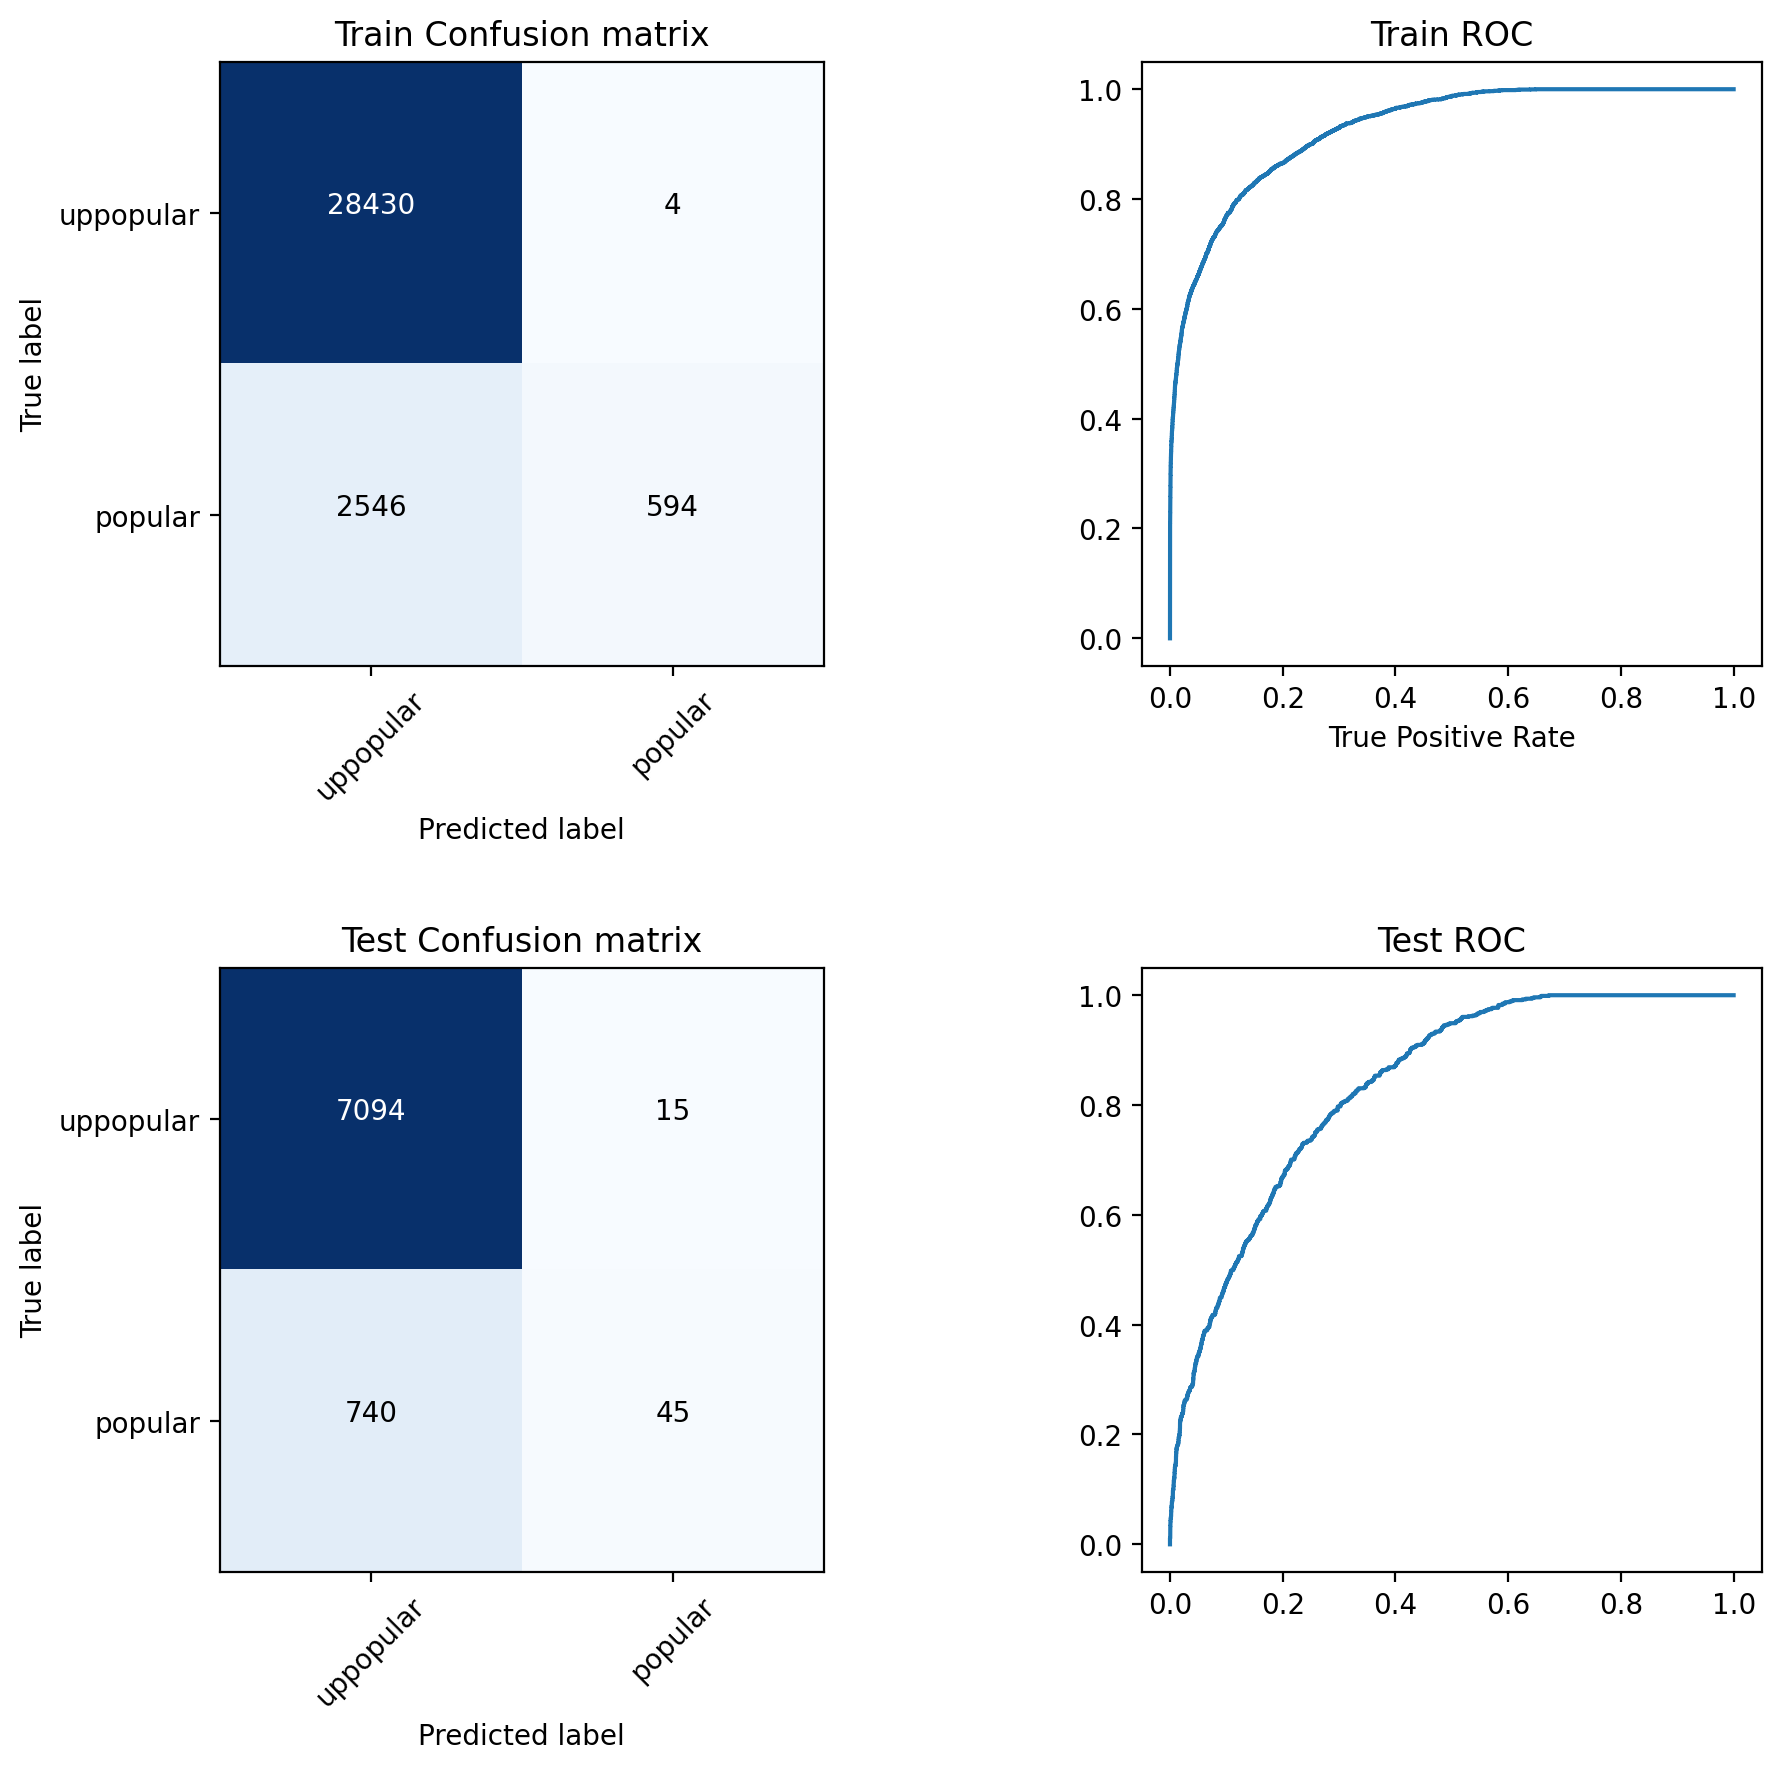

In [3]:
thresh = np.percentile(data.shares,[0,90])[1]
X_train, X_test, y_train, y_test = split_data(data.copy(),thresh,'popularity')
model = make_model(X_train,y_train)
test_model(model,(X_train, X_test), (y_train, y_test),print_score=False,plots=True)

# Optimization
In order to optimize the model there are two main ways we can change the set up
 - limiting points: in the exploritory models, these points were equalized evenly, maybe we could try limit points but in a way that still emulates the imbalance
 - parameter tuning: Use precision, recall, or f1_score to fine tune model parameters.

## Limiting Points
There are almost 20x more unpopular articles to popular articles so well try splitting that data such that there are 2, 5, 10, or 15 times more unpopular points to popular points

Ill choose a depth of 10 arbitratily for this portion

In [ ]:
# Set threshold of popularity to above the 90th percentile
thresh = np.percentile(data.shares,[0,90])[1]

limited_points_scores = pd.DataFrame()

split_range = range(0,10)

for i in range(10):
    for k in split_range:
        X_train, X_test, y_train, y_test = split_data(data.copy(),thresh,'popularity',lim_i=k)
        model = make_model(X_train,y_train)
        accuracy = test_model(model,(X_train, X_test), (y_train, y_test),print_score=False)
        limited_points_scores = limited_points_scores.append(accuracy.rename(index={0:k}))

As expected, no limiting gives the highest precision while limiting increases the recall.

To choose the best ratio, I'll start by prioritizing precision then taking the ratio with the highest f1 score of the top five.

In [ ]:
limited_points_scores = limited_points_scores.reset_index().groupby('index').mean()
lim = limited_points_scores[limited_points_scores.precision >= .70].sort_values('f1_score',ascending=False)
best_ratio = list(lim.head().index)[0]
print(best_ratio)

## Hyperparameter tuning

In [ ]:
# split based on selected limit ratio
X_train, X_test, y_train, y_test = split_data(data.copy(),thresh,'popularity',lim_i=best_ratio)

In [ ]:
# set up the params grid
grid_params = {'random_forest__max_depth':range(5,15),'random_forest__n_estimators':[50,100,150,200]}

# Use gridsearchCV scoring on the f1 score
best = best_params(X_train,y_train,grid_params,score='precision')
print(best)

model = make_model(X_train,y_train,best['random_forest__max_depth'],best['random_forest__n_estimators'])
test_model(model, (X_train, X_test), (y_train, y_test), plots=True, print_score=False)

In [ ]:
thresh = np.percentile(data.shares,[0,90])[1]

def final_optimization(data,thresh,y_var):
    # Seperate popular and unpopular points
    data = popularity(data,thresh=thresh,col_name=y_var)
    y_var_values = data[y_var].unique()
    
    # find best ratio
    limited_points_scores = pd.DataFrame()
    for i in range(10):
        for k in range(0,10):
            # limit data
            data_lim, _ = lim_entries(data,col_name=y_var,both=True,i=k)
            X = data_lim.drop(columns=y_var)
            y = data_lim[y_var].replace(y_var_values,range(len(y_var_values)))
            model = make_model(X,y)
            accuracy = test_model(model,X,y,print_score=False)
            limited_points_scores = limited_points_scores.append(accuracy.rename(index={0:k}))
    limited_points_scores = limited_points_scores.reset_index().groupby('index').mean()
    lim = limited_points_scores[limited_points_scores.precision >= .70].sort_values('f1_score',ascending=False)
    best_ratio = list(lim.head().index)[0]
    
    # make X, y 
    data, _ = lim_entries(data,col_name=y_var,both=True,i=k)
    X = data_lim.drop(columns=y_var)
    y = data_lim[y_var].replace(y_var_values,range(len(y_var_values)))
    
    # hyperparameters
    grid_params = {'random_forest__max_depth':range(5,15),'random_forest__n_estimators':[50,100,150,200]}
    best = best_params(X,y,grid_params,score='f1')
    
    # make and test model
    model = make_model(X,y,best['random_forest__max_depth'],best['random_forest__n_estimators'])
    test_model(model, (X,y, plots=True, print_score=True)
               
final_optimization(data.copy(),thresh,'popularity')